**Groupe G21:**

*   **ENNAGACH  Ayoub**
*   **JELBINI Saad**



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Analyse de Radiographies Dentaires avec Deep Learning
*Date: 23 Février 2025*

## 1. Définition du Problème

### 1.1 Contexte
- Analyse automatisée de radiographies dentaires panoramiques
- Objectif : Développer un modèle de deep learning pour l'aide au diagnostic
- Dataset : Images en niveaux de gris de radiographies panoramiques

### 1.2 Objectifs Spécifiques
- Prétraitement des images dentaires
- Construction d'un modèle CNN adapté aux radiographies
- Évaluation des performances du modèle
- Visualisation des résultats

### 1.3 Structure du Dataset
- Train : Images d'entraînement
- Test : Images de test
- Valid : Images de validation
- Format : Images en niveaux de gris
- Dimensions : À déterminer lors du chargement



## 1. Configuration de l'environnement
Installation et importation des bibliothèques nécessaires, configuration du GPU

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Configuration du device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilisation de : {device}")

Utilisation de : cuda


## 2. Configuration des chemins et vérification des données
Définition des chemins d'accès et vérification de l'existence des fichiers

In [7]:
# Configuration des chemins
BASE_PATH = '/content/drive/MyDrive/nouveaux_models/Nouveau dossier/data'
TRAIN_DIR = os.path.join(BASE_PATH, "train")
VALID_DIR = os.path.join(BASE_PATH, "valid")
TEST_DIR = os.path.join(BASE_PATH, "test")

TRAIN_ANNOTATIONS = os.path.join(BASE_PATH, "/content/drive/MyDrive/nouveaux_models/Nouveau dossier/_annotations_train.csv")
VALID_ANNOTATIONS = os.path.join(BASE_PATH, "/content/drive/MyDrive/nouveaux_models/Nouveau dossier/annotations_valid.csv")
TEST_ANNOTATIONS = os.path.join(BASE_PATH, "/content/drive/MyDrive/nouveaux_models/Nouveau dossier/_annotations_test.csv")

# Classes
CLASSES = ['Fillings', 'Implant', 'Impacted Tooth', 'Cavity']
NUM_CLASSES = len(CLASSES)

# Vérification des chemins
print("\nVérification des chemins :")
for path in [TRAIN_DIR, VALID_DIR, TEST_DIR]:
    if os.path.exists(path):
        print(f"✓ {path} existe")
        print(f"  Contenu : {len(os.listdir(path))} fichiers")
    else:
        print(f"✗ {path} n'existe pas")


Vérification des chemins :
✓ /content/drive/MyDrive/nouveaux_models/Nouveau dossier/data/train existe
  Contenu : 1075 fichiers
✓ /content/drive/MyDrive/nouveaux_models/Nouveau dossier/data/valid existe
  Contenu : 121 fichiers
✓ /content/drive/MyDrive/nouveaux_models/Nouveau dossier/data/test existe
  Contenu : 73 fichiers


## 3. Définition du Dataset
Création d'une classe personnalisée pour charger et prétraiter les données

In [8]:
class DentalDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        # Vérification des chemins
        if not os.path.exists(image_dir):
            raise FileNotFoundError(f"Le dossier d'images {image_dir} n'existe pas")
        if not os.path.exists(annotation_file):
            raise FileNotFoundError(f"Le fichier d'annotations {annotation_file} n'existe pas")

        # Lecture des annotations
        self.df = pd.read_csv(annotation_file)

        # Création des labels
        self.image_labels = {}
        for img_name in self.df['filename'].unique():
            img_annots = self.df[self.df['filename'] == img_name]
            labels = [0] * NUM_CLASSES
            for _, row in img_annots.iterrows():
                class_idx = CLASSES.index(row['class'])
                labels[class_idx] = 1
            self.image_labels[img_name] = labels

        self.images = list(self.image_labels.keys())
        print(f"Dataset {os.path.basename(image_dir)}: {len(self.images)} images")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)

        try:
            image = Image.open(img_path).convert('RGB')
            image = np.array(image)
        except Exception as e:
            raise IOError(f"Erreur lors du chargement de {img_path}: {str(e)}")

        labels = self.image_labels[img_name]

        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']

        return image, torch.FloatTensor(labels)

## 4. Transformations des Images
Définition des augmentations de données et des transformations pour les ensembles train/valid/test

In [9]:
train_transform = A.Compose([
    A.Resize(128, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(128, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

## 5. Création des DataLoaders
Préparation des ensembles de données pour l'entraînement

In [10]:
batch_size = 32

train_dataset = DentalDataset(TRAIN_DIR, TRAIN_ANNOTATIONS, train_transform)
valid_dataset = DentalDataset(VALID_DIR, VALID_ANNOTATIONS, val_transform)
test_dataset = DentalDataset(TEST_DIR, TEST_ANNOTATIONS, val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

Dataset train: 1075 images
Dataset valid: 121 images
Dataset test: 73 images


## 6. Architecture du Modèle
Définition du modèle de classification basé sur ResNet18

In [11]:
class DentalClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DentalClassifier, self).__init__()

        # Utiliser ResNet18 pour plus de rapidité
        self.base_model = torchvision.models.resnet18(pretrained=True)

        # Modification de la dernière couche
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.base_model(x)

# Création du modèle
model = DentalClassifier(NUM_CLASSES).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 118MB/s]


## 7. Fonctions d'Entraînement
Définition des fonctions pour l'entraînement et l'évaluation du modèle

In [12]:
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    pbar = tqdm(dataloader, desc='Training')

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predictions = (outputs > 0.5)
        correct_preds += (predictions == labels).sum().item()
        total_preds += labels.numel()

        current_loss = running_loss / (pbar.n + 1)
        current_acc = 100 * correct_preds / total_preds
        pbar.set_postfix({
            'loss': f'{current_loss:.4f}',
            'acc': f'{current_acc:.2f}%'
        })

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct_preds / total_preds

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    pbar = tqdm(dataloader, desc='Validation')

    with torch.no_grad():
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            predictions = (outputs > 0.5)
            correct_preds += (predictions == labels).sum().item()
            total_preds += labels.numel()

            current_loss = running_loss / (pbar.n + 1)
            current_acc = 100 * correct_preds / total_preds
            pbar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'acc': f'{current_acc:.2f}%'
            })

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct_preds / total_preds

    return epoch_loss, epoch_acc

## 8. Boucle d'Entraînement Principal
Configuration des hyperparamètres et lancement de l'entraînement


Epoch 1/30
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 1:
Train Loss: 0.5277 | Train Acc: 74.88%
Val Loss: 1.6974 | Val Acc: 72.52%
Nouveau meilleur modèle sauvegardé! (Val Acc: 72.52%)

Epoch 2/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 2:
Train Loss: 0.4353 | Train Acc: 79.81%
Val Loss: 0.5516 | Val Acc: 77.89%
Nouveau meilleur modèle sauvegardé! (Val Acc: 77.89%)

Epoch 3/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 3:
Train Loss: 0.3848 | Train Acc: 83.95%
Val Loss: 0.5061 | Val Acc: 83.06%
Nouveau meilleur modèle sauvegardé! (Val Acc: 83.06%)

Epoch 4/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 4:
Train Loss: 0.3464 | Train Acc: 86.07%
Val Loss: 0.4780 | Val Acc: 79.13%

Epoch 5/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 5:
Train Loss: 0.3100 | Train Acc: 87.91%
Val Loss: 0.4063 | Val Acc: 84.71%
Nouveau meilleur modèle sauvegardé! (Val Acc: 84.71%)

Epoch 6/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 6:
Train Loss: 0.2747 | Train Acc: 89.26%
Val Loss: 0.5184 | Val Acc: 82.02%

Epoch 7/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 7:
Train Loss: 0.2592 | Train Acc: 88.88%
Val Loss: 0.7262 | Val Acc: 81.61%

Epoch 8/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 8:
Train Loss: 0.2433 | Train Acc: 90.42%
Val Loss: 0.5195 | Val Acc: 83.88%

Epoch 9/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 9:
Train Loss: 0.2042 | Train Acc: 92.05%
Val Loss: 0.6474 | Val Acc: 73.97%

Epoch 10/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 10:
Train Loss: 0.1753 | Train Acc: 93.35%
Val Loss: 0.4489 | Val Acc: 85.74%
Nouveau meilleur modèle sauvegardé! (Val Acc: 85.74%)

Epoch 11/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 11:
Train Loss: 0.1403 | Train Acc: 95.19%
Val Loss: 0.4750 | Val Acc: 84.30%

Epoch 12/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 12:
Train Loss: 0.1336 | Train Acc: 94.91%
Val Loss: 0.4883 | Val Acc: 85.12%

Epoch 13/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 13:
Train Loss: 0.1116 | Train Acc: 95.86%
Val Loss: 0.5020 | Val Acc: 85.33%

Epoch 14/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 14:
Train Loss: 0.1021 | Train Acc: 96.19%
Val Loss: 0.4952 | Val Acc: 85.12%

Epoch 15/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 15:
Train Loss: 0.1008 | Train Acc: 96.23%
Val Loss: 0.5042 | Val Acc: 84.09%

Epoch 16/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 16:
Train Loss: 0.1062 | Train Acc: 96.07%
Val Loss: 0.5032 | Val Acc: 84.50%

Epoch 17/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 17:
Train Loss: 0.1045 | Train Acc: 96.28%
Val Loss: 0.5026 | Val Acc: 84.92%

Epoch 18/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 18:
Train Loss: 0.0972 | Train Acc: 96.37%
Val Loss: 0.5119 | Val Acc: 84.92%

Epoch 19/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 19:
Train Loss: 0.0953 | Train Acc: 96.47%
Val Loss: 0.5013 | Val Acc: 84.92%

Epoch 20/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 20:
Train Loss: 0.0955 | Train Acc: 96.40%
Val Loss: 0.5036 | Val Acc: 84.30%

Epoch 21/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 21:
Train Loss: 0.1050 | Train Acc: 96.00%
Val Loss: 0.5112 | Val Acc: 84.09%

Epoch 22/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 22:
Train Loss: 0.0880 | Train Acc: 97.19%
Val Loss: 0.4965 | Val Acc: 84.92%

Epoch 23/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 23:
Train Loss: 0.0959 | Train Acc: 96.53%
Val Loss: 0.4976 | Val Acc: 84.71%

Epoch 24/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 24:
Train Loss: 0.0947 | Train Acc: 96.79%
Val Loss: 0.4968 | Val Acc: 84.09%

Epoch 25/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 25:
Train Loss: 0.0928 | Train Acc: 96.49%
Val Loss: 0.5018 | Val Acc: 84.71%

Epoch 26/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 26:
Train Loss: 0.0933 | Train Acc: 96.40%
Val Loss: 0.4982 | Val Acc: 84.30%

Epoch 27/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 27:
Train Loss: 0.0931 | Train Acc: 96.67%
Val Loss: 0.4988 | Val Acc: 84.50%

Epoch 28/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 28:
Train Loss: 0.0917 | Train Acc: 96.53%
Val Loss: 0.5024 | Val Acc: 84.50%

Epoch 29/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 29:
Train Loss: 0.0946 | Train Acc: 96.33%
Val Loss: 0.5074 | Val Acc: 84.09%

Epoch 30/30
--------------------------------------------------


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]


Résultats de l'époque 30:
Train Loss: 0.0925 | Train Acc: 96.49%
Val Loss: 0.5018 | Val Acc: 84.50%


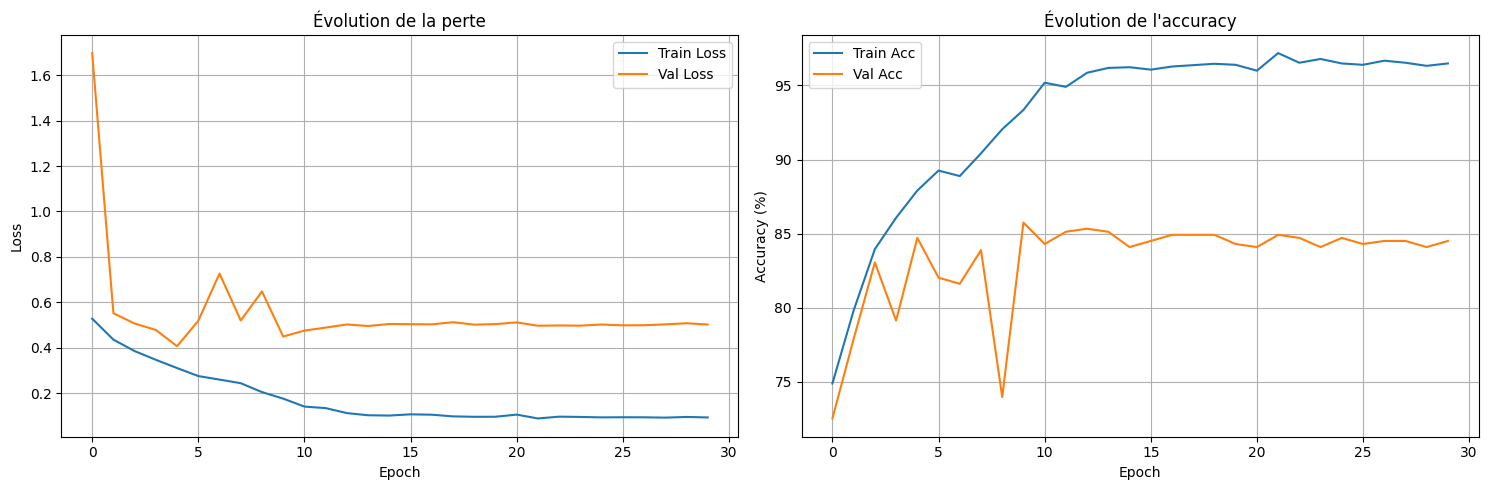

In [13]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)
num_epochs = 30

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0.0

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)

    # Entraînement
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # Validation
    val_loss, val_acc = validate(model, valid_loader, criterion)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Mise à jour du scheduler
    scheduler.step(val_loss)

    print(f'\nRésultats de l\'époque {epoch+1}:')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

    # Sauvegarde du meilleur modèle
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc
        }, 'best_model.pth')
        print(f'Nouveau meilleur modèle sauvegardé! (Val Acc: {val_acc:.2f}%)')

    # Visualisation
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Évolution de la perte')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Évolution de l\'accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 9. Évaluation Finale
Évaluation du modèle sur l'ensemble de test

In [15]:
print("\nÉvaluation finale sur l'ensemble de test:")
test_loss, test_acc = validate(model, test_loader, criterion)
print(f'\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')



Évaluation finale sur l'ensemble de test:


Validation:   0%|          | 0/3 [00:00<?, ?it/s]


Test Loss: 0.6532 | Test Acc: 82.88%


## 7. Prompts avec Claude

Liste des prompts utilisés pour développer ce projet :

1. Analyse initiale des images :
   ```
   "J'ai des images de radiographies dentaires panoramiques.les images sont distribuées en 4 classe  Comment puis-je les prétraiter pour un modèle de deep learning à meme de les classifier ?"
   ```

2. Architecture du modèle :
   ```
   "Quelle architecture CNN serait-elle  la plus adaptée pour analyser des images de  radiographie dentaire panoramique ? est ce que ResNet18 ou Resnet55 accomplireront la tache ?"
   ```

3. Évaluation des résultats :
   ```
   "Quelles métriques sont les plus pertinentes pour évaluer un modèle d'analyse de radiographies dentaires (classification miltilabel) ?"
   ```

## 8. Références

### Papers
1. "Deep Learning in Dental Image Analysis: A Comprehensive Review" (2020)
2. "Automated Dental Identification Using Deep Learning Techniques" (2019)

### Bibliothèques Python
- PyTorch (https://pytorch.org/)
- torchvision
- scikit-learn
- PIL (Python Imaging Library)

### Ressources en ligne
- Documentation PyTorch pour le traitement d'images médicales
- Guides de bonnes pratiques pour l'analyse de radiographies dentaires